# SLAM

- Задачи (построение карты глубины, облака точек, нахождение калибровки)
- Ключевые точки, дескрипторы

In [20]:
!git clone -b main https://github.com/haminhtien99/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 575, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 575 (delta 3), reused 7 (delta 2), pack-reused 566
Receiving objects: 100% (575/575), 72.05 MiB | 29.62 MiB/s, done.
Resolving deltas: 100% (154/154), done.


## Загрузка данных

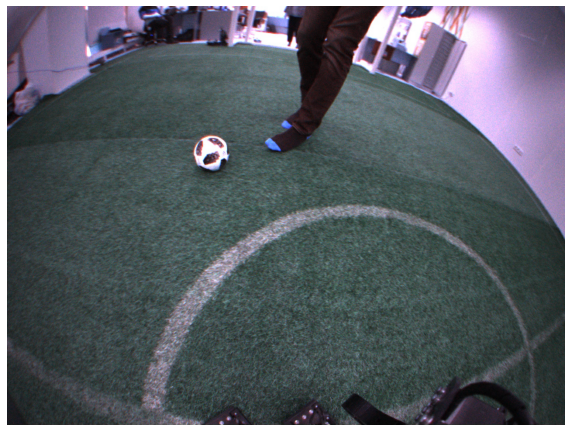

In [25]:
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

img_orig = cv2.imread("/content/cvr_course/cvr_course/data/imgs/ball.png")

plt.imshow (img_orig)
plt.axis('off')
plt.show()

## Градиенты

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


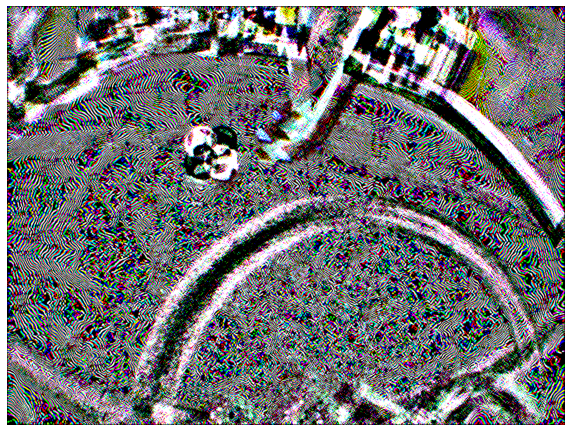

In [30]:
img = img_orig.copy()

img_blurred = cv2.blur(img, (50, 50))
grads = cv2.Sobel(img_blurred, cv2.CV_64F, 1, 1, ksize=7)

plt.imshow(grads)
plt.axis('off')
plt.show()

## Фильтр Харриса

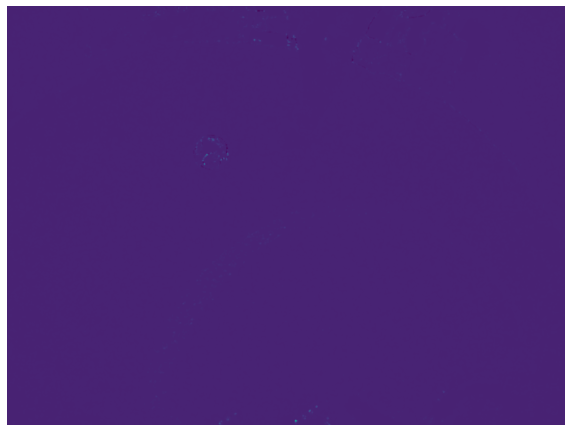

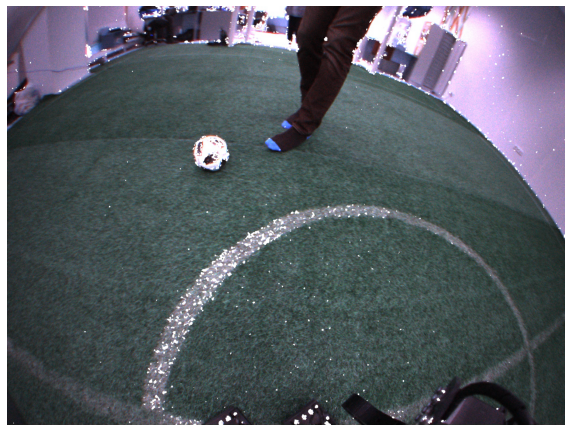

In [32]:
def show_harris(img):
    single_channel = img [:, :, 0].copy()
    
    bsz = 5 # block size
    asz = 3 # aperture size
    k   = 0.04 # alg parameter

    dst = cv2.cornerHarris(single_channel, bsz, asz, k)
    img[dst > 0.005 * dst.max()] = 255#белый цвет

    plt.imshow(dst)
    plt.axis('off')
    plt.show()

    plt.imshow(img)
    plt.axis('off')
    plt.show()


img = img_orig.copy()
show_harris (img)

## Template match

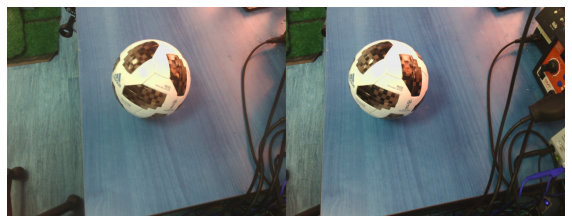

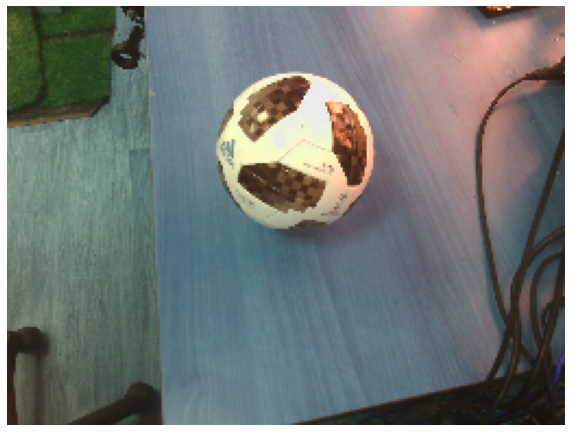

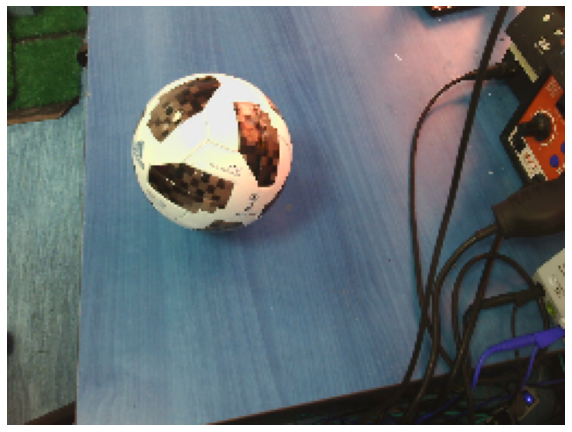

In [34]:
img = cv2.imread ("/content/cvr_course/cvr_course/data/imgs/stereopairs/sp2.jpg")

plt.imshow (img)
plt.axis ('off')
plt.show ()

img_downsampled = cv2.resize (img, (512, 192))

img_1_downsampled = img_downsampled [:, :256, :]
img_2_downsampled = img_downsampled [:, 256:, :]

plt.imshow (img_1_downsampled)
plt.axis ('off')
plt.show ()

plt.imshow (img_2_downsampled)
plt.axis ('off')
plt.show ()

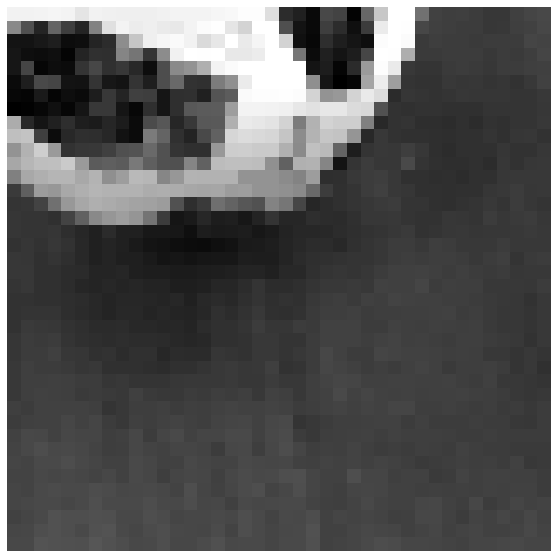

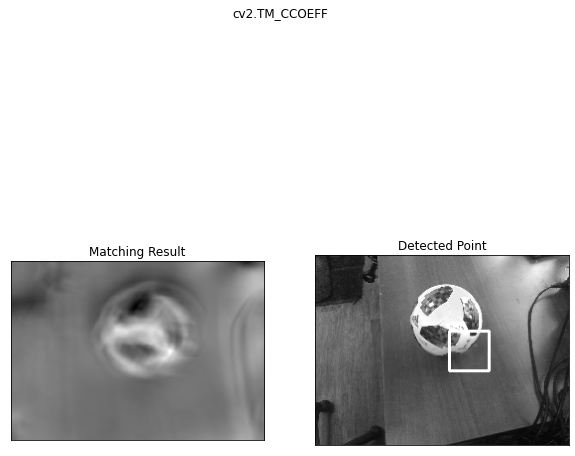

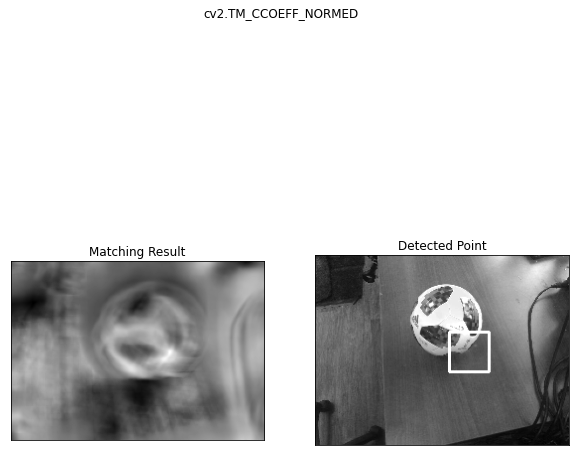

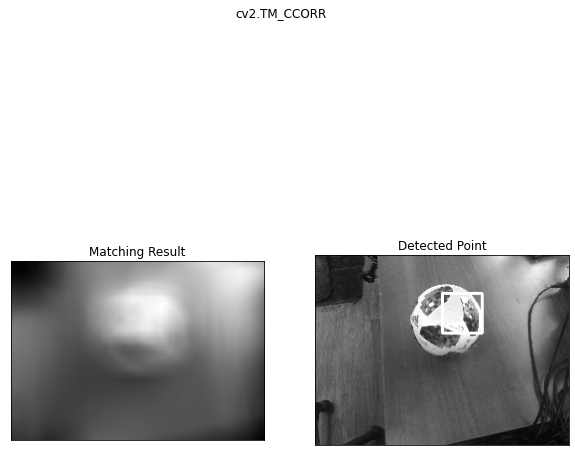

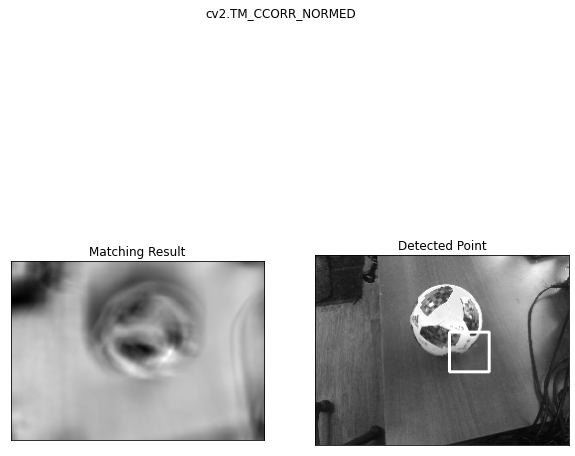

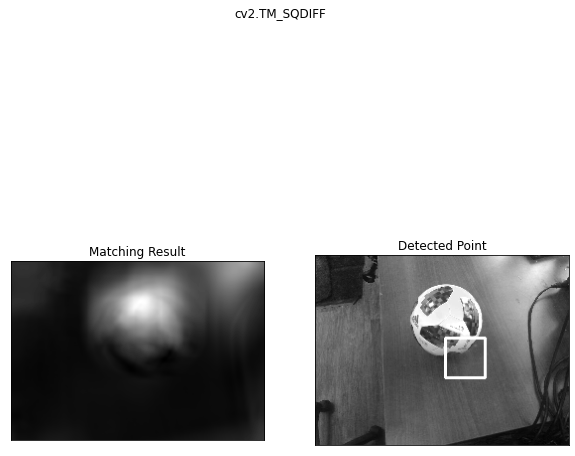

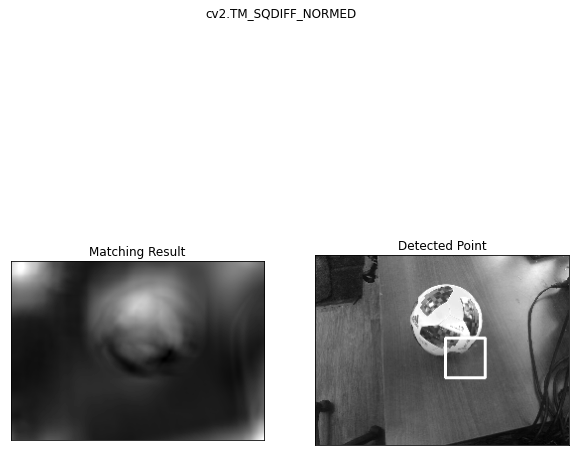

In [37]:
img = img_1_downsampled.copy() [:, :, 0]
img2 = img.copy()
template = cv2.resize (img_2_downsampled [70:150, 70:150, 0], (40, 40))
w, h = template.shape[::-1]

plt.imshow (template,cmap = 'gray')
plt.axis ('off')
plt.show ()

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

## Дескрипторы

[[ 74 191 184 ...  84 135  91]
 [109 106 128 ...  23  74  65]
 [ 73 162  16 ... 180  74   9]
 ...
 [203 184  51 ...  12 139 127]
 [ 42 159  43 ... 140 246  91]
 [204 214  60 ... 209 228  99]]
[[ 75 186 184 ...   4 143 219]
 [203 189 185 ...  80 167 123]
 [ 67 186 185 ... 132 135 123]
 ...
 [ 11  18 106 ... 132  79  93]
 [ 75  24  43 ... 132 121 124]
 [ 12 115  59 ... 131  71 240]]


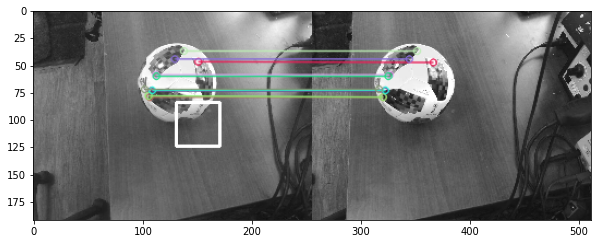

(<matplotlib.image.AxesImage at 0x7f6ac09eb610>, None)

In [38]:
# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img,None)
kp2, des2 = orb.detectAndCompute(img_2_downsampled [:, :, 0],None)

print (des1)
print (des2)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches (img,kp1,img_2_downsampled [:, :, 0],kp2,matches[:10],None,
                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

## Как там с сетками обстоит вопрос?